In [19]:
import pandas as pd

# Load the data from the CSV file
file_path = 'gb.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to verify correct loading and to understand the structure of the data
data.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,London,51.5072,-0.1275,United Kingdom,GB,"London, City of",primary,11262000,8825001
1,Birmingham,52.4800,-1.9025,United Kingdom,GB,Birmingham,NaN,2919600,1137100
2,Portsmouth,50.8058,-1.0872,United Kingdom,GB,Portsmouth,NaN,855679,248440
3,Southampton,50.9025,-1.4042,United Kingdom,GB,Southampton,NaN,855569,271173
4,Nottingham,52.9561,-1.1512,United Kingdom,GB,Nottingham,NaN,729977,289301


In [20]:
# Select only the necessary columns and rename them for consistency
filtered_data = data[['city', 'lat', 'lng', 'population']].copy()
filtered_data.columns = ['City', 'Latitude', 'Longitude', 'Population']

# Sort the data by population in descending order and handle ties by keeping all tied entries
filtered_data_sorted = filtered_data.sort_values(by='Population', ascending=False)

# Get the top 50 cities, taking ties into account
# We need to include all cities that tie with the 50th city's population if there are any
population_cutoff = filtered_data_sorted.iloc[49]['Population']
top_cities = filtered_data_sorted[filtered_data_sorted['Population'] >= population_cutoff]

# Display the resulting top cities to confirm selection and count
top_cities.head(), top_cities.shape

(          City  Latitude  Longitude  Population
 0       London   51.5072    -0.1275    11262000
 1   Birmingham   52.4800    -1.9025     2919600
 2   Portsmouth   50.8058    -1.0872      855679
 3  Southampton   50.9025    -1.4042      855569
 4   Nottingham   52.9561    -1.1512      729977,
 (50, 4))

In [23]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from itertools import permutations

# Calculate the distance matrix for the cities
coords = top_cities[['Latitude', 'Longitude']]
distance_matrix = squareform(pdist(coords, metric='euclidean'))

def calculate_total_distance(route, distance_matrix):
    """ Calculate total distance of a route based on the distance matrix. """
    total_distance = sum(distance_matrix[route[i], route[i+1]] for i in range(len(route)-1))
    total_distance += distance_matrix[route[-1], route[0]]  # return to start
    return total_distance

def two_opt(route, distance_matrix):
    """ Implements the 2-opt algorithm to find a shorter path. """
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1: continue  # changes nothing, skip
                new_route = route[:i] + route[i:j][::-1] + route[j:]
                if calculate_total_distance(new_route, distance_matrix) < calculate_total_distance(best, distance_matrix):
                    best = new_route
                    improved = True
        route = best
    return best

# Create an initial route (simply ordered by city index)
initial_route = list(range(50))

# Apply the 2-opt algorithm to find a more efficient route
optimized_route = two_opt(initial_route, distance_matrix)

# Get the city names in the optimized order and calculate the total distance
optimized_city_names = top_cities.iloc[optimized_route]['City'].tolist()
total_distance = calculate_total_distance(optimized_route, distance_matrix)

optimized_city_names, total_distance

(['London',
  'Westminster',
  'Croydon',
  'Islington',
  'Tottenham',
  'Walthamstow',
  'Ilford',
  'Romford',
  'Maidstone',
  'Basildon',
  'Chelmsford',
  'Colchester',
  'Norwich',
  'Cambridge',
  'Luton',
  'Harrow',
  'High Wycombe',
  'Slough',
  'Worthing',
  'Portsmouth',
  'Southampton',
  'Bournemouth',
  'Plymouth',
  'Bristol',
  'Gloucester',
  'Coventry',
  'Solihull',
  'Birmingham',
  'West Bromwich',
  'Wolverhampton',
  'Stockport',
  'Sale',
  'Manchester',
  'Rochdale',
  'Blackburn',
  'Warrington',
  'Liverpool',
  'Blackpool',
  'Belfast',
  'Aberdeen',
  'Gateshead',
  'York',
  'Bradford',
  'Rotherham',
  'Derby',
  'Nottingham',
  'Leicester',
  'Northampton',
  'Oxford',
  'Basingstoke'],
 32.891759280511806)

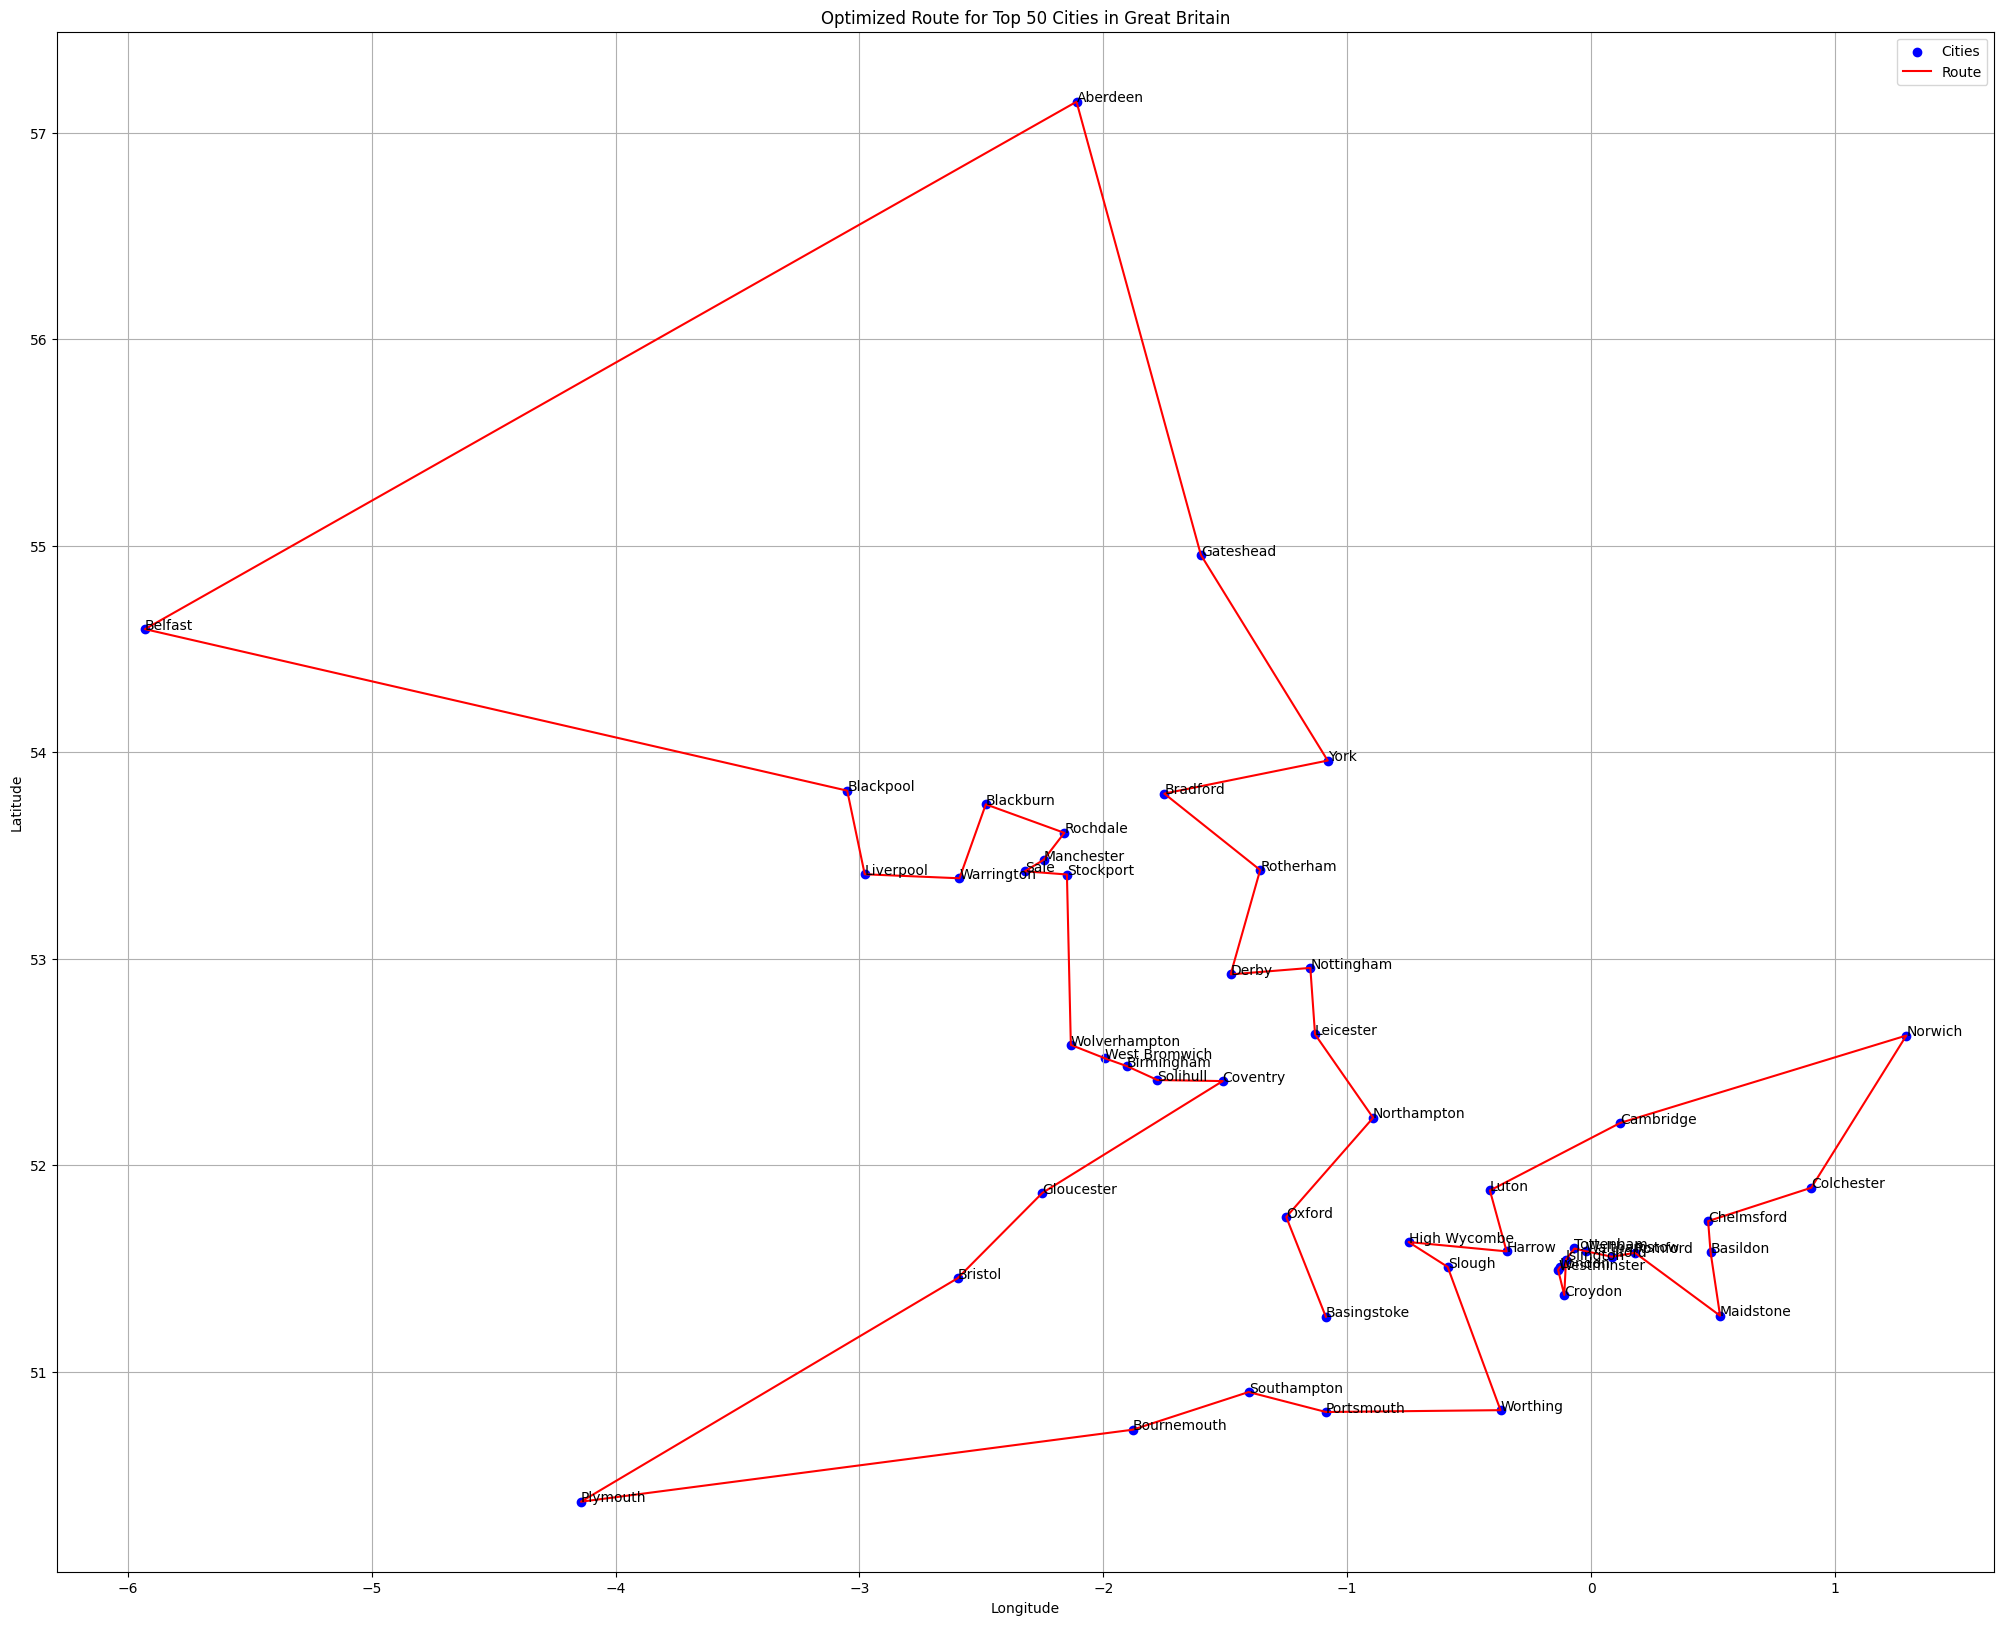

In [16]:
import matplotlib.pyplot as plt

# Extract coordinates for the optimized route
route_coords = coords.iloc[optimized_route]

# Plotting the route on a map
plt.figure(figsize=(25, 20))
plt.scatter(route_coords['Longitude'], route_coords['Latitude'], c='blue', label='Cities')
plt.plot(route_coords['Longitude'], route_coords['Latitude'], c='red', label='Route')

# Annotate cities
for i, txt in enumerate(optimized_city_names):
    plt.annotate(txt, (route_coords.iloc[i]['Longitude'], route_coords.iloc[i]['Latitude']))

plt.title('Optimized Route for Top 50 Cities in Great Britain')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from math import radians, cos, sin, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the Haversine distance between two points on the earth (specified in decimal degrees)."""
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    return c * r

def calculate_total_haversine_distance(route, coords):
    """ Calculate total Haversine distance of a route. """
    total_distance = 0
    for i in range(len(route)-1):
        lat1, lon1 = coords.iloc[route[i]][['Latitude', 'Longitude']]
        lat2, lon2 = coords.iloc[route[i+1]][['Latitude', 'Longitude']]
        total_distance += haversine_distance(lat1, lon1, lat2, lon2)
    # Add distance to return to the starting city
    lat1, lon1 = coords.iloc[route[-1]][['Latitude', 'Longitude']]
    lat2, lon2 = coords.iloc[route[0]][['Latitude', 'Longitude']]
    total_distance += haversine_distance(lat1, lon1, lat2, lon2)
    return total_distance

# Calculate the total Haversine distance for the optimized route
total_haversine_distance = calculate_total_haversine_distance(optimized_route, route_coords)
total_haversine_distance

9758.626442537763

In [ ]:
#sqqq